##Model Rechef


Import Libraries

In [ ]:
## Import Libraries

import gdown
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


Mount Google Drive and Download Dataset

In [ ]:
## Mount Google Drive and Download Dataset

from google.colab import drive
drive.mount('/content/drive')

# Download file from Google Drive
file_id = '1hgbVDCF2KmHwbtPnvMJjm-jRk2jRc0r5'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'DatasetBahanV1.zip', quiet=False)

# Extract zip file
zip_path = 'DatasetBahanV1.zip'
extract_path = '/content/DatasetBahanMakanan'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Data Augmentation and Preprocessing

In [ ]:
## Data Augmentation and Preprocessing

# Load and preprocess dataset with strong data augmentation
def load_data(data_dir, img_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=0.2  # Using 20% of the data for validation
    )

    train_data = train_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    val_data = val_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    return train_data, val_data


Learning Rate Scheduler

In [ ]:
## Learning Rate Scheduler

# Scheduler for adjusting learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


Model Building

In [ ]:
## Model Building

# Model with Transfer Learning and further Fine-Tuning
def build_transfer_model_with_finetuning(img_size, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    base_model.trainable = True  # Unfreeze the base model

    fine_tune_at = 50  # Fine-tuning more layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Increased regularization
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


Model Training

In [ ]:
## Model Training

# Train model with callback LearningRateScheduler
def train_model(model, train_data, val_data, epochs, learning_rate):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
        EarlyStopping(monitor = 'val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001),
        LearningRateScheduler(scheduler)
    ]
    history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=callbacks)
    return history


Plot Training History

In [ ]:
## Plot Training History

# Function to display training results
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()


Preprocess Single Image

In [ ]:
## Preprocess Single Image

# Preprocess image for consistency
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    return image


Model Evaluation

In [ ]:
## Model Evaluation

# Evaluate using confusion matrix and classification report
def evaluate_model(model, val_data):
    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_data.classes

    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(classification_report(y_true, y_pred_classes, target_names=val_data.class_indices.keys()))


Main Function

In [ ]:
# Main function
if __name__ == '__main__':
    data_dir = extract_path  # Path to the dataset directory after extraction
    img_size = (224, 224)
    batch_size = 32
    epochs = 50
    learning_rate = 0.000005

    train_data, val_data = load_data(data_dir, img_size, batch_size)
    num_classes = len(train_data.class_indices)

    model = build_transfer_model_with_finetuning(img_size, num_classes)
    history = train_model(model, train_data, val_data, epochs, learning_rate)

    model_save_path = '/content/drive/MyDrive/rechefmodel.h5'
    model.save(model_save_path)  # Path to save the model

    plot_history(history)

    # Evaluate the model
    evaluate_model(model, val_data)

##SINGLE OBJECT DETECTION >80% Valid

Link Dataset dan Model

In [ ]:
#Dataset Link
#https://drive.google.com/file/d/1hgbVDCF2KmHwbtPnvMJjm-jRk2jRc0r5/view?usp=drive_link

#Model Link
#https://drive.google.com/file/d/1mr6ZbaCw6bR8XARsOm5FCpVmrQ-oLmKb/view?usp=drive_link

Single Object Detection

In [ ]:
import gdown
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Hubungkan ke Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unduh file Model.h5 dari Google Drive
file_id = '1mr6ZbaCw6bR8XARsOm5FCpVmrQ-oLmKb'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'rechefmodel.h5', quiet=False)

# Unduh file Dataset dari Google Drive
file_id = '1hgbVDCF2KmHwbtPnvMJjm-jRk2jRc0r5'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'DatasetBahanV1.zip', quiet=False)

# Ekstrak file Dataset zip
zip_path = 'DatasetBahanV1.zip'
extract_path = '/content/DatasetBahanMakanan'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load the trained model
model = tf.keras.models.load_model('/content/rechefmodel.h5')

# Load class indices from the 'train' directory
data_dir = '/content/DatasetBahanMakanan'
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Changed target size to 224x224
    batch_size=32,
    class_mode='categorical'
)
class_indices = train_data.class_indices
class_names = list(class_indices.keys())

# Define a simplified custom augment function for resize only
def custom_augment(image):
    image = tf.image.resize(image, [224, 224])  # Changed target size to 224x224
    return image

# Preprocess Image with Resize
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0

    # Convert to tensor and apply augmentations (resize only)
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = custom_augment(image_tensor)

    return image_tensor

# Predict and Check Food
def recommend_food(image_path, model, class_names, threshold=0.8):
    # Preprocess the image
    image = preprocess_image(image_path, (224, 224))  # Changed target size to 224x224

    # Ensure the tensor shape is correct
    image = tf.reshape(image, (1, 224, 224, 3))  # Changed target size to 224x224

    # Predict the class
    predictions = model.predict(image)
    max_prob = np.max(predictions)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class[0]]

    # Determine if the prediction is a food item
    if max_prob >= threshold:
        result = f"Nama: {predicted_class_name}, Kemiripan: {max_prob*100:.2f}%"
    else:
        result = "Invalid atau tidak bahan makanan"

    # Display the image
    plt.imshow(load_img(image_path))
    plt.title(result)
    plt.axis('off')
    plt.show()

    return result

def generate_ingredient_list(image_paths, model, class_names, threshold=0.8):
    ingredient_list = []
    for i, image_path in enumerate(image_paths):
        result = recommend_food(image_path, model, class_names, threshold)
        ingredient_list.append(f"{i+1}. {result}")

    return ingredient_list

Mounted at /content/drive


Downloading...
From: https://drive.google.com/uc?id=1mr6ZbaCw6bR8XARsOm5FCpVmrQ-oLmKb
To: /content/rechefmodel.h5
100%|██████████| 31.0M/31.0M [00:00<00:00, 37.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hgbVDCF2KmHwbtPnvMJjm-jRk2jRc0r5
From (redirected): https://drive.google.com/uc?id=1hgbVDCF2KmHwbtPnvMJjm-jRk2jRc0r5&confirm=t&uuid=ccc15fb1-c751-406e-ac05-21906fddf1c7
To: /content/DatasetBahanV1.zip
100%|██████████| 67.4M/67.4M [00:00<00:00, 85.1MB/s]


Found 3996 images belonging to 8 classes.


Test 1

In [ ]:

# Main Function untuk merekomendasikan bahan makanan
def main():
    # Upload image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        image_path = os.path.join('/content', image_name)
        result = recommend_food(image_path, model, class_names)
        print(f"Result for {image_name}: {result}")

if __name__ == '__main__':
    main()

Test 2

In [ ]:

# Main Function untuk merekomendasikan bahan makanan
def main():
    # Upload image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        image_path = os.path.join('/content', image_name)
        result = recommend_food(image_path, model, class_names)
        print(f"Result for {image_name}: {result}")

if __name__ == '__main__':
    main()

Test 3

In [ ]:

# Main Function untuk merekomendasikan bahan makanan
def main():
    # Upload image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        image_path = os.path.join('/content', image_name)
        result = recommend_food(image_path, model, class_names)
        print(f"Result for {image_name}: {result}")

if __name__ == '__main__':
    main()

Test 4

In [ ]:

# Main Function untuk merekomendasikan bahan makanan
def main():
    # Upload image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        image_path = os.path.join('/content', image_name)
        result = recommend_food(image_path, model, class_names)
        print(f"Result for {image_name}: {result}")

if __name__ == '__main__':
    main()

Test 5

In [ ]:

# Main Function untuk merekomendasikan bahan makanan
def main():
    # Upload image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        image_path = os.path.join('/content', image_name)
        result = recommend_food(image_path, model, class_names)
        print(f"Result for {image_name}: {result}")

if __name__ == '__main__':
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From: https://drive.google.com/uc?id=1mr6ZbaCw6bR8XARsOm5FCpVmrQ-oLmKb
To: /content/rechefmodel.h5
100%|██████████| 31.0M/31.0M [00:01<00:00, 17.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hgbVDCF2KmHwbtPnvMJjm-jRk2jRc0r5
From (redirected): https://drive.google.com/uc?id=1hgbVDCF2KmHwbtPnvMJjm-jRk2jRc0r5&confirm=t&uuid=34fb1c24-8b38-4d29-b4c0-d7033250de05
To: /content/DatasetBahanV1.zip
100%|██████████| 67.4M/67.4M [00:00<00:00, 84.0MB/s]


Found 3996 images belonging to 8 classes.


Saving test#9.jpg to test#9.jpg
1/1 [==============================] - 1s 895ms/step


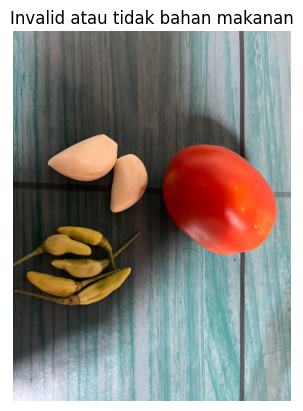

Result for test#9.jpg:
Invalid atau tidak bahan makanan


In [ ]:
import gdown
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Hubungkan ke Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unduh file Model.h5 dari Google Drive
file_id = '1mr6ZbaCw6bR8XARsOm5FCpVmrQ-oLmKb'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'rechefmodel.h5', quiet=False)

# Unduh file Dataset dari Google Drive
file_id = '1hgbVDCF2KmHwbtPnvMJjm-jRk2jRc0r5'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'DatasetBahanV1.zip', quiet=False)

# Ekstrak file Dataset zip
zip_path = 'DatasetBahanV1.zip'
extract_path = '/content/DatasetBahanMakanan'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load the trained model
model = tf.keras.models.load_model('/content/rechefmodel.h5')

# Load class indices from the 'train' directory
data_dir = '/content/DatasetBahanMakanan'
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Changed target size to 224x224
    batch_size=32,
    class_mode='categorical'
)
class_indices = train_data.class_indices
class_names = list(class_indices.keys())

# Define a simplified custom augment function for resize only
def custom_augment(image):
    image = tf.image.resize(image, [224, 224])  # Changed target size to 224x224
    return image

# Preprocess Image with Resize
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0

    # Convert to tensor and apply augmentations (resize only)
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = custom_augment(image_tensor)

    return image_tensor

# Predict and Check Food
def recommend_food(image_path, model, class_names, threshold=0.8):
    # Preprocess the image
    image = preprocess_image(image_path, (224, 224))  # Changed target size to 224x224

    # Ensure the tensor shape is correct
    image = tf.reshape(image, (1, 224, 224, 3))  # Changed target size to 224x224

    # Predict the class
    predictions = model.predict(image)
    top_indices = predictions[0].argsort()[-4:][::-1]  # Get top 4 predictions

    results = []
    for i in top_indices:
        prob = predictions[0][i]
        class_name = class_names[i]
        if prob >= threshold:
            results.append(f"Nama: {class_name}, Kemiripan: {prob*100:.2f}%")

    if not results:
        results.append("Invalid atau tidak bahan makanan")

    # Display the image
    plt.imshow(load_img(image_path))
    plt.title("\n".join(results))
    plt.axis('off')
    plt.show()

    return results

# Main Function untuk merekomendasikan bahan makanan
def main():
    # Upload image
    uploaded = files.upload()

    for image_name in uploaded.keys():
        image_path = os.path.join('/content', image_name)
        results = recommend_food(image_path, model, class_names)
        print(f"Result for {image_name}:")
        for result in results:
            print(result)

if __name__ == '__main__':
    main()
